### Aggregation and Grouping

In [1]:
import numpy as np
import pandas as pd

class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

# Planets Data

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets') # tap dl dinh nghia san
planets.shape

(1035, 6)

In [7]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


### Simple Aggregation in Pandas

Earlier, we explored some of the data aggregations available for NumPy arrays ("Aggregations: Min, Max, and Everything In Between"). As with a one-dimensional NumPy array, for a Pandas Series the aggregates return a single value:

In [19]:
rng = np.random.RandomState(42)

ser = pd.Series(rng.rand(5))
ser


0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [26]:
(0.156019 + 0.598658+0.731994+ 0.950714+ 0.374540)/5

0.562385

In [21]:
ser.sum()

2.811925491708157

In [22]:
ser.mean() # avg all array. 

0.5623850983416314

In [24]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [25]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

In [27]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

In [28]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:
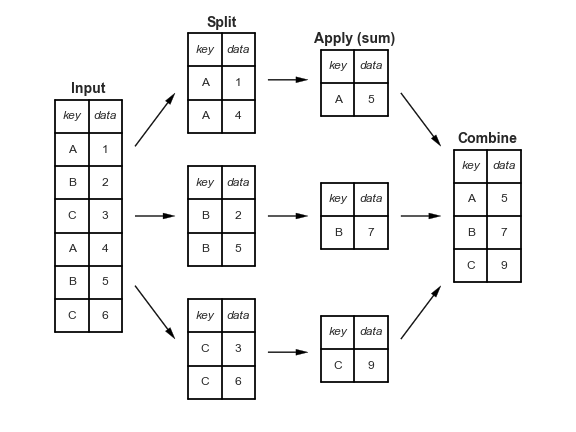


### GroupBy: Split, Apply, Combine

This makes clear what the groupby accomplishes:

The split step involves breaking up and grouping a DataFrame depending on the value of the specified key.
The apply step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
The combine step merges the results of these operations into an output array.
While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that the intermediate splits do not need to be explicitly instantiated. Rather, the GroupBy can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way. The power of the GroupBy is that it abstracts away these steps: the user need not think about how the computation is done under the hood, but rather thinks about the operation as a whole.

As a concrete example, let's take a look at using Pandas for the computation shown in this diagram. We'll start by creating the input DataFrame:

In [29]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


 The most basic split-apply-combine operation can be computed with the groupby() method of DataFrames, passing the name of the desired key column:

In [31]:
df.groupby('key')

In [32]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


## The GroupBy object

aggregate, filter, transform, and apply

Column indexing
The GroupBy object supports column indexing in the same way as the DataFrame, and returns a modified GroupBy object. For example:

In [33]:
planets.groupby('method')

In [34]:
planets.groupby('method')['orbital_period']

In [35]:
planets.groupby('method')['orbital_period'].median()


method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

## Iteration over groups

The GroupBy object supports direct iteration over the groups, returning each group as a Series or DataFrame:

In [36]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for doing certain things manually, though it is often much faster to use the built-in apply functionality, which we will discuss momentarily.

In [41]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.0
       Eclipse Timing Variations           9.0
       Imaging                            38.0
       Microlensing                       23.0
       Orbital Brightness Modulation       3.0
                                         ...  
max    Pulsar Timing                    2011.0
       Pulsation Timing Variations      2007.0
       Radial Velocity                  2014.0
       Transit                          2014.0
       Transit Timing Variations        2014.0
Length: 80, dtype: float64

Looking at this table helps us to better understand the data: for example, the vast majority of planets have been discovered by the Radial Velocity and Transit methods, though the latter only became common (due to new, more accurate telescopes) in the last decade. The newest methods seem to be Transit Timing Variation and Orbital Brightness Modulation, which were not used to discover a new planet until 2011.

This is just one example of the utility of dispatch methods. Notice that they are applied to each individual group, and the results are then combined within GroupBy and returned. Again, any valid DataFrame/Series method can be used on the corresponding GroupBy object, which allows for some very flexible and powerful operations!

## Aggregate, filter, transform, apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available. In particular, GroupBy objects have aggregate(), filter(), transform(), and apply() methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this DataFrame:

In [38]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


### Aggregation

In [42]:
df.groupby('key').aggregate(['min', np.median, max])

data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

In [43]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': 'max'})

,data1,data2
key,,
A,0,5
B,1,7
C,2,9


In [44]:
def filter_func(x):
    return x['data2'].std() > 4

display('df', "df.groupby('key').std()", "df.groupby('key').filter(filter_func)")


df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby('key').std()
       data1     data2
key                   
A    2.12132  1.414214
B    2.12132  4.949747
C    2.12132  4.242641

df.groupby('key').filter(filter_func)
  key  data1  data2
1   B      1      0
2   C      2      3
4   B      4      7
5   C      5      9

In [45]:
df.groupby('key').transform(lambda x: x - x.mean())


,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


### The apply() method

The apply() method lets you apply an arbitrary function to the group results. The function should take a DataFrame, and return either a Pandas object (e.g., DataFrame, Series) or a scalar; the combine operation will be tailored to the type of output returned.

For example, here is an apply() that normalizes the first column by the sum of the second:

In [46]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

display('df', "df.groupby('key').apply(norm_by_data2)")

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9
,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3


### Specifying the split key

### A list, array, series, or index providing the grouping keys¶

In [47]:
L = [0, 1, 0, 1, 2, 0]
display('df', 'df.groupby(L).sum()')

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(L).sum()
   data1  data2
0      7     17
1      4      3
2      4      7

In [48]:
display('df', "df.groupby(df['key']).sum()")

df
  key  data1  data2
0   A      0      5
1   B      1      0
2   C      2      3
3   A      3      3
4   B      4      7
5   C      5      9

df.groupby(df['key']).sum()
     data1  data2
key              
A        3      8
B        5      7
C        7     12

In [49]:
df2 = df.set_index('key')
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
display('df2', 'df2.groupby(mapping).sum()')

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
consonant,12,19
vowel,3,8


#### Any Python function 

In [50]:
display('df2', 'df2.groupby(str.lower).mean()')


,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9
,data1,data2
a,1.5,4.0
b,2.5,3.5


###  A list of valid keys

In [51]:
df2.groupby([str.lower, mapping]).mean()

,,data1,data2
a,vowel,1.5,4.0
b,consonant,2.5,3.5
c,consonant,3.5,6.0


In [54]:
decade.shape

(1035,)

### Grouping example

As an example of this, in a couple lines of Python code we can put all these together and count discovered planets by method and by decade

In [52]:
decade = 10 * (planets['year'] // 10)
decade = decade.astype(str) + 's'
decade.name = 'decade'
planets.groupby(['method', decade])['number'].sum().unstack().fillna(0)

decade,1980s,1990s,2000s,2010s
method,,,,
Astrometry,0.0,0.0,0.0,2.0
Eclipse Timing Variations,0.0,0.0,5.0,10.0
Imaging,0.0,0.0,29.0,21.0
Microlensing,0.0,0.0,12.0,15.0
Orbital Brightness Modulation,0.0,0.0,0.0,5.0
Pulsar Timing,0.0,9.0,1.0,1.0
Pulsation Timing Variations,0.0,0.0,1.0,0.0
Radial Velocity,1.0,52.0,475.0,424.0
Transit,0.0,0.0,64.0,712.0
